In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, skew, kurtosis
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
#Problem 1

In [3]:
n = 1000
sim = np.random.randn(n)
#create function for kurtosis skewness calculation
def calKurtosisSkewness(sample):
    n = sample.size
    μ_hat = sum(sample)/n
    m = np.ones(n) * μ_hat
    sim_corrected = sample - m
    sim_c_t = sim_corrected.T
    cm2 = sum(sim_c_t*sim_corrected)/n
    sq = np.sqrt(cm2*cm2*cm2)
    skew_hat = sum(sim_corrected**3)/n/sq
    kurt_hat = sum(sim_corrected**4)/n/cm2**2
    excess_kurt = kurt_hat - 3
    return skew_hat, excess_kurt
#create the amount of repeatition
samples = 100
temp = []
kurt = []
skew = []
for i in range (0, samples):
    temp.append(calKurtosisSkewness(np.random.randn(n)))
for j in range (0, len(temp)):
    skew.append(temp[j][0])
for h in range(0, len(temp)):
    kurt.append(temp[h][1])
#calculate the average of 100 results
exkurt_func = sum(kurt)/len(kurt)
skew_func = sum(skew)/len(skew)
print("skewness calculated from my function:", skew_func)
print("excess kurtosis calculated from my function:", exkurt_func)

skewness calculated from my function: 0.002496781058375659
excess kurtosis calculated from my function: -0.0027746871508631797


In [4]:
# problem 2

In [5]:
my_data = np.genfromtxt('problem2.csv', delimiter=',')
my_data = np.delete(my_data, 0, 0)
x_d = my_data[:, 0].reshape(-1, 1)
y_d = my_data[:, 1].reshape(-1, 1)

In [6]:
# (a)

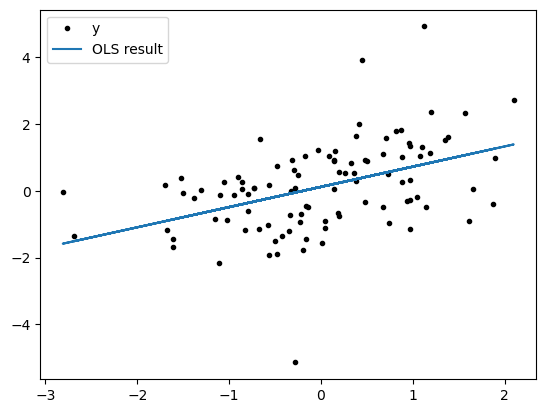

In [7]:
#fit the data using OLS
reg = LinearRegression()
reg.fit(x_d,y_d)
y_pre = reg.predict(x_d)
plt.figure()
plt.plot(x_d, y_d, 'k.', label = 'y')
plt.plot(x_d, y_pre, label = 'OLS result')
plt.legend()
plt.show()

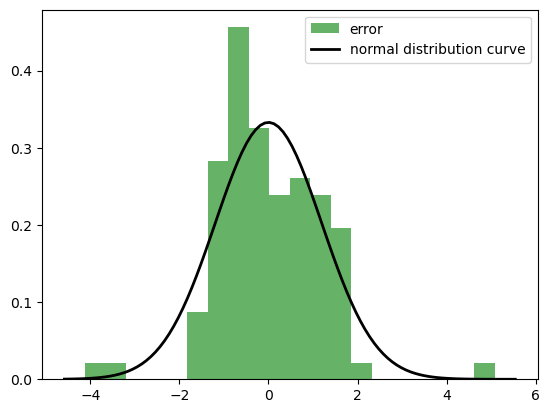

In [8]:
#calculate error vector and plot the hist
error = (y_pre - y_d)
m,std = norm.fit(error)
plt.figure()
plt.hist(error, bins=20, density=True, alpha=0.6, color='g', label = 'error')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, m, std)
plt.plot(x, p, 'k', linewidth=2, label = 'normal distribution curve')
plt.legend()
plt.show()

In [9]:
# (b)

In [10]:
#create class for MLE fitting
class MLE:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    #normal distribution
    def normal_nll(self, p):
        m_hat = p[0]   
        b = p[1]
        sigma = p[2]
        error_dist = norm(0, sigma)
        error_term = self.y - b - m_hat * self.x
        nll = -np.log(error_dist.pdf(error_term)).sum()
        return nll
    
    #t distribution
    def t_nll(self, p):
        m_hat = p[0]   
        b = p[1]
        df = p[2]
        scale = p[3]
        error_dist = t(df, scale)
        error_term = self.y - b - m_hat * self.x
        nll = -np.log(error_dist.pdf(error_term)).sum()
        return nll
    
    # optimization for normal dirtribution
    def normal_optimization(self, init_p):
        result = minimize(self.normal_nll, init_p, method='BFGS')
        return result
    
    # optimization for t distribution
    def t_optimization(self, init_p):
        result = minimize(self.t_nll, init_p, method='BFGS')
        return result

In [11]:
mle = MLE(x_d, y_d)

# solve for optimization for normal distribution
init_p = [1, 1, 1]
result_norm = mle.normal_optimization(init_p)
print(result_norm)

      fun: 159.9920966891624
 hess_inv: array([[ 1.52793963e-02, -9.96610827e-05, -3.21303421e-04],
       [-9.96610827e-05,  1.42497576e-02, -7.34120871e-05],
       [-3.21303421e-04, -7.34120871e-05,  7.45410185e-03]])
      jac: array([ 0.00000000e+00, -1.90734863e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([0.60520482, 0.11983619, 1.1983941 ])


In [12]:
init_p = [1, 1, 1, 1]
result_t = mle.t_optimization(init_p)
print(result_t)

      fun: 155.515287275789
 hess_inv: array([[ 1.43065629e-02,  9.67868104e-04,  1.37922049e-02,
         9.67868104e-04],
       [ 9.67868104e-04,  5.03339763e-01, -9.43834797e-03,
        -4.96660237e-01],
       [ 1.37922049e-02, -9.43834797e-03,  7.69516711e+00,
        -9.43834797e-03],
       [ 9.67868104e-04, -4.96660237e-01, -9.43834797e-03,
         5.03339763e-01]])
      jac: array([-1.90734863e-06,  3.81469727e-06,  1.90734863e-06,  3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([0.55893054, 0.06998072, 6.75734749, 0.06998072])


In [13]:
m_norm = result_norm.x[0]
b_norm = result_norm.x[1]
y_pre_mle_norm = m_norm * x_d + b_norm
m_t = result_t.x[0]
b_t = result_t.x[1]
y_pre_mle_t = m_t * x_d + b_t

# SSE
SSE_norm = np.square(y_pre_mle_norm - y_d).sum()
SSE_t = np.square(y_pre_mle_t - y_d).sum()
print('SSE_normal_dist =', SSE_norm, ', SSE_t_dist =', SSE_t)

# AIC 
AIC_norm = 2 * len(result_norm.x) - 2 * (-result_norm.fun)
AIC_t = 2 * len(result_t.x) - 2 * (-result_t.fun)
print('AIC_normal_dist =', AIC_norm, ', AIC_t_dist =', AIC_t)

# BIC
BIC_norm = len(result_norm.x) * np.log(len(y_d)) - 2 * (-result_norm.fun)
BIC_t = len(result_t.x) * np.log(len(y_d)) - 2 * (-result_t.fun)
print('BIC_normal_dist =', BIC_norm, ', BIC_t_dist =', BIC_t)

SSE_normal_dist = 143.61484854062613 , SSE_t_dist = 144.06627090325546
AIC_normal_dist = 325.9841933783248 , AIC_t_dist = 319.030574551578
BIC_normal_dist = 333.79970393628906 , BIC_t_dist = 329.45125529553036


In [14]:
# (c)

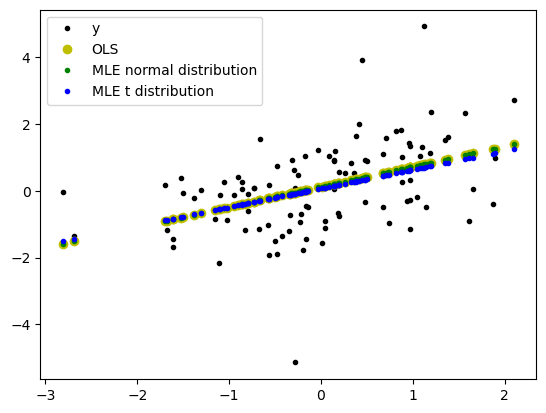

In [15]:
# OLS, MLE normal dist and MLE t dist plot
plt.figure()
plt.plot(x_d, y_d, 'k.', label='y')
plt.plot(x_d, y_pre, 'yo', label='OLS')
plt.plot(x_d, y_pre_mle_norm, 'g.', label='MLE normal distribution')
plt.plot(x_d, y_pre_mle_t, 'b.', label='MLE t distribution')
plt.legend()
plt.show()

In [16]:
# print the parameters fitted by MLE normal
print('m =', result_norm.x[0], ', b =', result_norm.x[1])

m = 0.6052048185684211 , b = 0.11983618580674067


In [17]:
# print the parameters fitted by MLE t
print('m =', result_t.x[0], ', b =', result_t.x[1])

m = 0.5589305448467985 , b = 0.06998072394891108


In [18]:
# problem 3

In [19]:
ar0 = np.array([1])
ma0 = np.array([1])
#set seed
np.random.seed(1000)

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


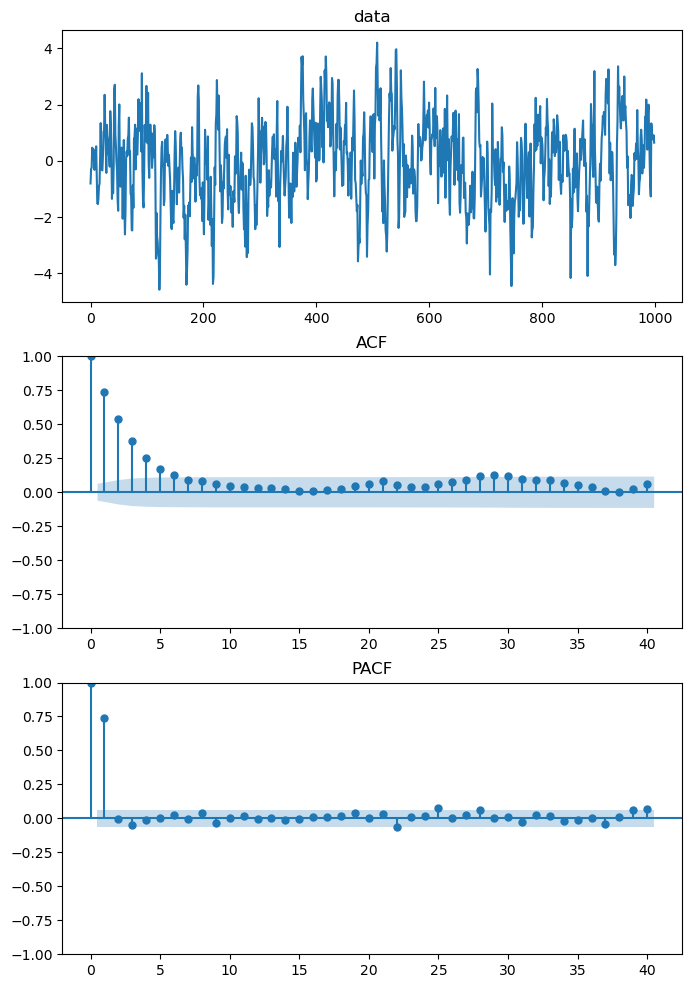

In [20]:
# AR(1)
ar1 = np.array([1, -0.75])
ar1_process = ArmaProcess(ar1, ma0)
ar1_simulate = ar1_process.generate_sample(nsample=1000)
alpha = 0.05
lags = 40
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ar1_simulate)
plot_acf(ar1_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ar1_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


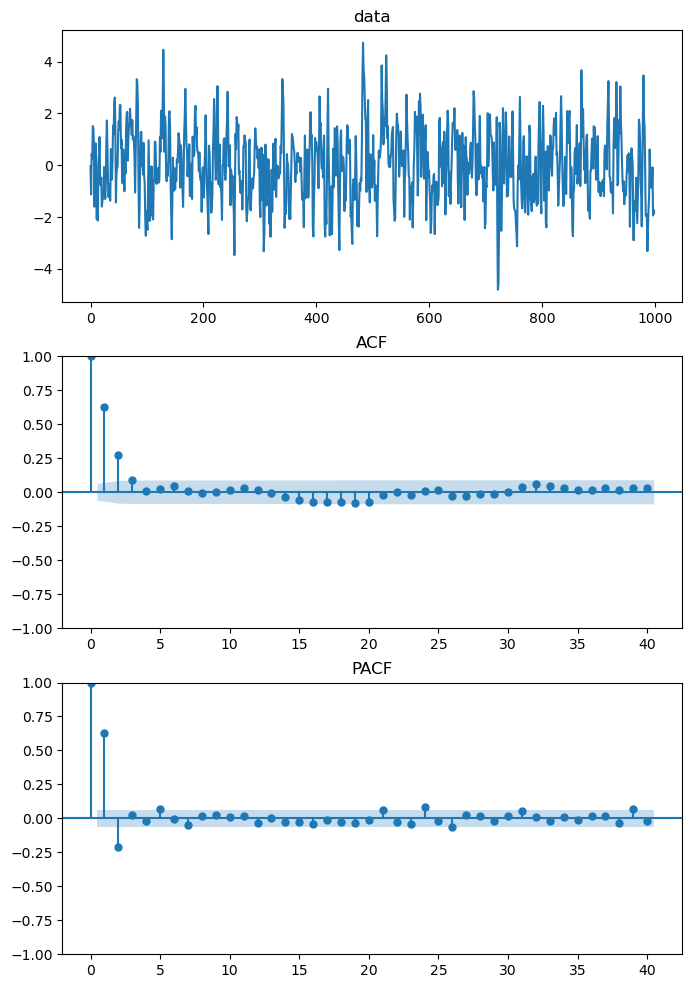

In [21]:
# AR(2)
ar2 = np.array([1, -0.75, 0.25])
ar2_process = ArmaProcess(ar2, ma0)
ar2_simulate = ar2_process.generate_sample(nsample=1000)
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ar2_simulate)
plot_acf(ar2_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ar2_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


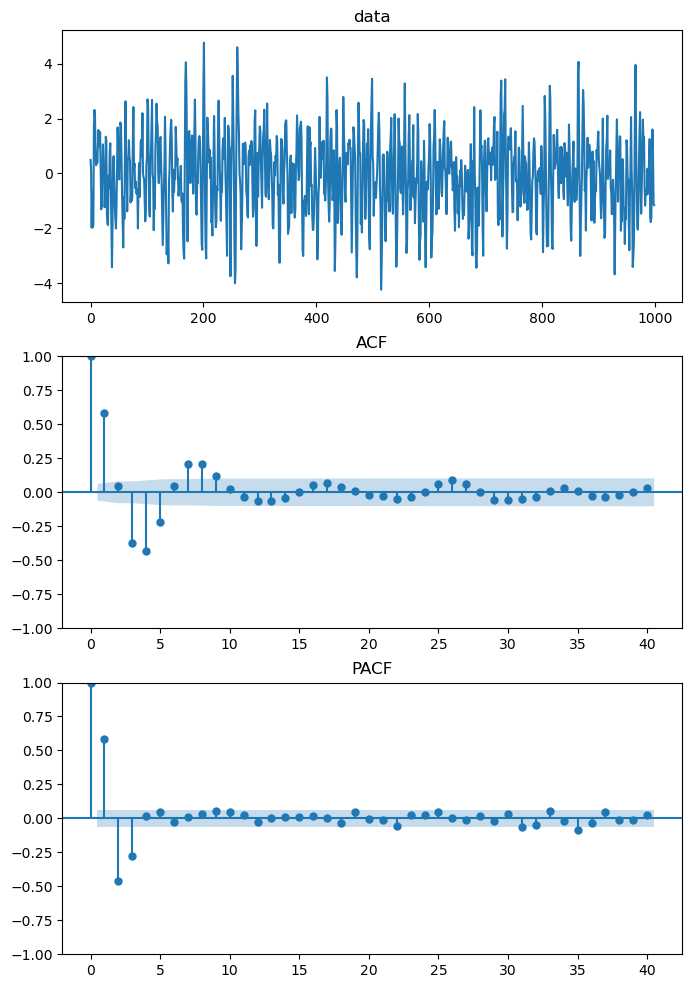

In [22]:
# AR(3)
ar3 = np.array([1, -0.75, 0.25, 0.25])
ar3_process = ArmaProcess(ar3, ma0)
ar3_simulate = ar3_process.generate_sample(nsample=1000)
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ar3_simulate)
plot_acf(ar3_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ar3_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


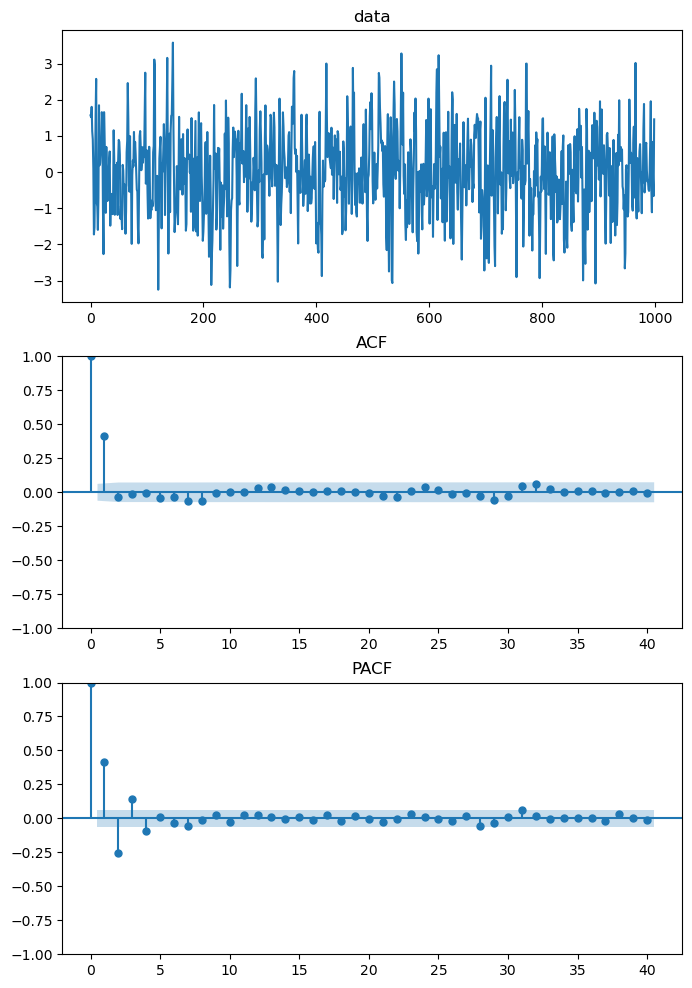

In [23]:
# MA(1)
ma1 = np.array([1, 0.65])
ma1_process = ArmaProcess(ar0, ma1)
ma1_simulate = ma1_process.generate_sample(nsample=1000)
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ma1_simulate)
plot_acf(ma1_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ma1_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


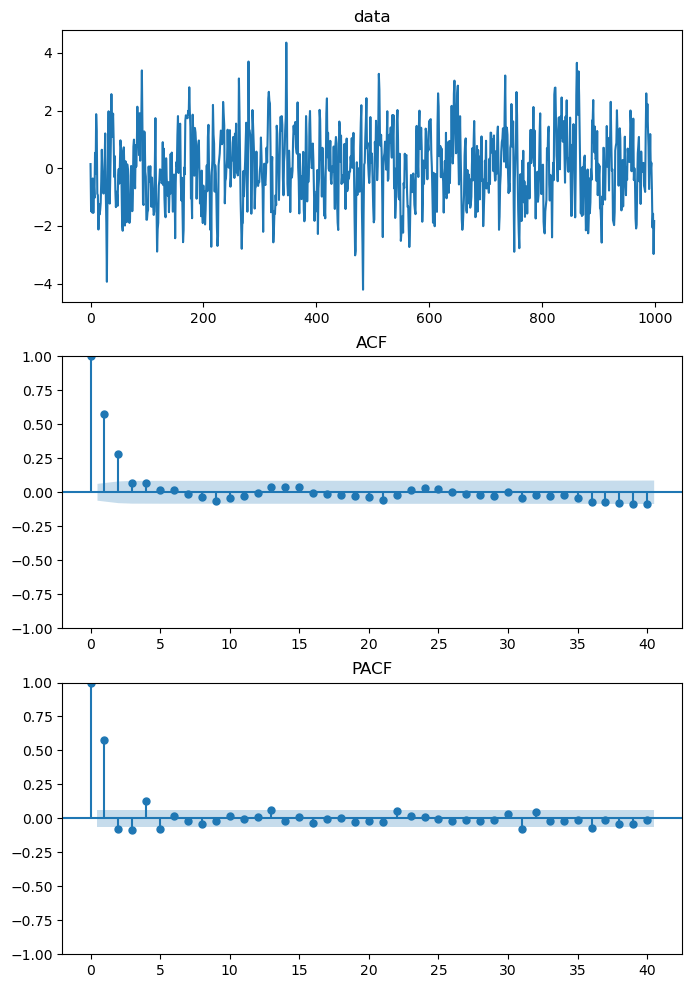

In [24]:
# MA(2)
ma2 = np.array([1, 0.65, 0.35])
ma2_process = ArmaProcess(ar0, ma2)
ma2_simulate = ma2_process.generate_sample(nsample=1000)
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ma2_simulate)
plot_acf(ma2_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ma2_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()

/Users/pudong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


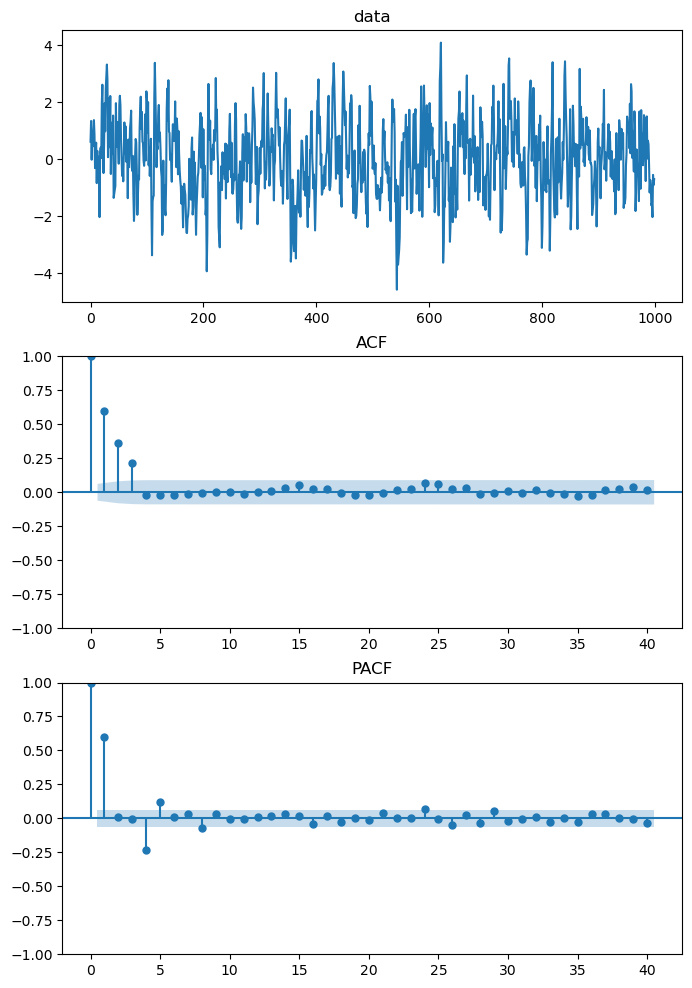

In [25]:
# MA(3)
ma3 = np.array([1, 0.65, 0.35, 0.35])
ma3_process = ArmaProcess(ar0, ma3)
ma3_simulate = ma3_process.generate_sample(nsample=1000)
figu, graph = plt.subplots(3, 1, figsize=(8, 12))
graph[0].plot(ma3_simulate)
plot_acf(ma3_simulate, alpha=alpha, lags=lags, ax=graph[1])
plot_pacf(ma3_simulate, alpha=alpha, lags=lags, ax=graph[2])
graph[0].set_title('data')
graph[1].set_title('ACF')
graph[2].set_title('PACF')
plt.show()